In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent  
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")


Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
from hydro_forecasting.data.lazy_datamodule import HydroLazyDataModule
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from sklearn.pipeline import Pipeline
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer
from hydro_forecasting.data.caravanify_parquet import (
    CaravanifyParquet,
    CaravanifyParquetConfig,
)

from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml

from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator


---

In [3]:
yaml_path = Path("/Users/cooper/Desktop/hydro-forecasting/notebooks/tide.yaml")

tide_hp = hp_from_yaml("tide", yaml_path)
tide_hp

{'decoder_output_size': 24,
 'dropout': 0.4040330172235821,
 'future_forcing_projection_size': 0,
 'future_input_size': 9,
 'group_identifier': 'gauge_id',
 'hidden_size': 110,
 'input_len': 34,
 'input_size': 10,
 'learning_rate': 0.00029399848560567596,
 'num_decoder_layers': 2,
 'num_encoder_layers': 2,
 'output_len': 10,
 'past_feature_projection_size': 0,
 'scheduler_factor': 0.5,
 'scheduler_patience': 5,
 'static_size': 10,
 'temporal_decoder_hidden_size': 51,
 'use_layer_norm': False}

In [4]:
config_ca = CaravanifyParquetConfig(
    attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
    shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/shapefiles",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

caravan_ca = CaravanifyParquet(config_ca)
basin_ids = caravan_ca.get_all_gauge_ids()[:10]

# basin_ids = [bid for bid in basin_ids if bid != "CA_15030"]

caravan_ca.load_stations(basin_ids)

In [5]:
config_us = CaravanifyParquetConfig(
    attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/timeseries/csv",
    shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/USA/post_processed/shapefiles",
    gauge_id_prefix="USA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

caravan_us = CaravanifyParquet(config_us)
basin_ids += caravan_us.get_all_gauge_ids()[:10]

In [6]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    # "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

In [7]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": static_features},
}

In [8]:
region_time_series_base_dirs = {
    "CA": "/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv/CA",
    "USA": "/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/timeseries/csv/USA",
}

region_static_attributes_base_dirs = {
    "CA": "/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes/CA",
    "USA": "/Users/cooper/Desktop/CaravanifyParquet/USA/post_processed/attributes/USA",
}

datamodule = HydroLazyDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/yolo_6",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target="streamflow",
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=basin_ids,
    is_autoregressive=True,
    files_per_batch=20,
)

datamodule.prepare_data()
datamodule.setup()

INFO: Found existing processed data with matching configuration


Creating index entries: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


INFO: Created training dataset with 94882 samples
INFO: Created validation dataset with 47694 samples
INFO: Created test dataset with 47437 samples


In [9]:
import sys
from pympler import asizeof  # Import asizeof

ie = datamodule.val_index_path

# Calculate size using pympler.asizeof
size_ie_mb = asizeof.asizeof(ie) / (1024 * 1024)
print(f"Approximate deep size of index entries in memory: {size_ie_mb:.2f} MB")

# Calculate size using pympler.asizeof
size_datamodule_mb = asizeof.asizeof(datamodule) / (1024 * 1024)
print(f"Approximate deep size of datamodule in memory: {size_datamodule_mb:.2f} MB")

Approximate deep size of index entries in memory: 0.00 MB
Approximate deep size of datamodule in memory: 0.27 MB


In [10]:
ie

PosixPath('/Users/cooper/Desktop/hydro-forecasting/tests/yolo_6/5af0c3ea-c280-59e5-83f0-bcf41247b3ab/index_files/val_index.parquet')

## Verify static data

In [11]:
# test_dataset = datamodule.test_dataset
# if not test_dataset:
#     print("Test dataset not found.")
# elif len(test_dataset) == 0:
#     print("Test dataset is empty.")
# else:
#     print(f"Test dataset size: {len(test_dataset)}")
#     # --- Get a Sample ---
#     sample_index = 1654
#     print(f"Getting sample at index {sample_index}...")
#     try:
#         sample = test_dataset[sample_index]

#         # --- Check for NaNs in the Sample Tensors ---
#         print("\n--- Checking for NaNs in sample tensors ---")
#         for key, tensor in sample.items():
#             if isinstance(tensor, torch.Tensor):
#                 has_nan = torch.isnan(tensor).any().item()
#                 print(f"Tensor'{key}' shape: {tensor.shape}, Contains NaNs: {has_nan}")
#                 print(f"  Sample tensor '{key}': {tensor[:5]}")
#                 if has_nan:
#                     # Optional: Print where NaNs occur
#                     nan_indices = torch.nonzero(torch.isnan(tensor))
#                     print(f"  NaN indices in '{key}': {nan_indices.tolist()[:5]}...") # Print first 5
#             else:
#                 print(f"Item '{key}' is not a tensor (type: {type(tensor)})")

#     except IndexError:
#         print(f"Error: Index {sample_index} out of bounds for dataset size {len(test_dataset)}")
#     except Exception as e:
#         print(f"An error occurred while getting or checking the sample: {e}")

In [12]:
# ie = datamodule.val_index_entries[1661]

# file_path = ie["file_path"]
# start_idx = ie["start_idx"]
# end_idx = ie["end_idx"]
# gauge_id = ie["gauge_id"]

# data = pd.read_parquet(file_path)

# # Slice the data
# data_slice = data.iloc[start_idx:end_idx]
# print(f"Data slice shape: {data_slice.shape}")

# data_slice["streamflow"]

## Let's try training a model

In [13]:
input_length = datamodule.input_length
output_length = datamodule.output_length

config = TiDEConfig(**tide_hp)


# Instantiate the Lightning module.
model = LitTiDE(config)

In [14]:
import pytorch_lightning as pl

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="gpu",
    devices=1,
)

# Train the model
trainer.fit(model, datamodule)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type      | Params | Mode 
----------------------------------------------------
0 | mse_criterion | MSELoss   | 0      | train
1 | model         | TiDEModel | 250 K  | train
----------------------------------------------------
250 K     Trainable params
0         Non-trainable params
250 K     Total params
1.001     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


INFO: prepare_data() has already been run; skipping.
INFO: Created training dataset with 94882 samples
INFO: Created validation dataset with 47694 samples


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 4: 100%|██████████| 47/47 [00:33<00:00,  1.41it/s, v_num=82]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 47/47 [00:33<00:00,  1.41it/s, v_num=82]


In [15]:
models_and_datamodules = {
    "TiDE": (model, datamodule),
}

evaluator = TSForecastEvaluator(
    horizons=list(range(1, output_length + 1)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={
        "accelerator": "cpu",
        "devices": 1,
    },
)

In [16]:
results = evaluator.test_models()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing TiDE...
INFO: prepare_data() has already been run; skipping.
INFO: Created test dataset with 47437 samples


/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Testing DataLoader 0: 100%|██████████| 24/24 [00:08<00:00,  2.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5217812061309814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Evaluating results with shape: preds=(47425, 10), obs=(47425, 10), basin_ids=(47425,)


In [17]:
df = results["TiDE"]["df"]

In [18]:
df

,horizon,prediction,observed,basin_id,date
0,1,6.692154,8.000000,CA_15013,2017-05-28
1,2,7.028462,7.500000,CA_15013,2017-05-29
2,3,5.733322,7.500000,CA_15013,2017-05-30
3,4,5.957889,6.559999,CA_15013,2017-05-31
4,5,6.880226,6.559999,CA_15013,2017-06-01
...,...,...,...,...,...
474245,6,0.372453,0.140000,USA_01073000,2014-09-23
474246,7,0.312292,0.110000,USA_01073000,2014-09-24
474247,8,0.538450,0.100000,USA_01073000,2014-09-25
474248,9,-0.059661,0.090000,USA_01073000,2014-09-26


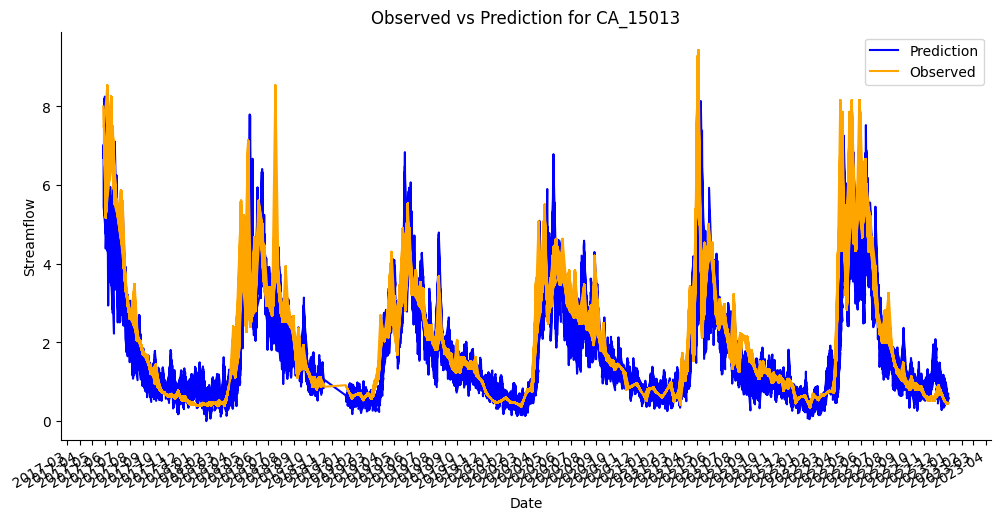

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

basin_id = "CA_15013"
df_basin = df[df["basin_id"] == basin_id]

plt.figure(figsize=(12, 6))
plt.plot(df_basin["date"], df_basin["prediction"], label="Prediction", color="blue")
plt.plot(df_basin["date"], df_basin["observed"], label="Observed", color="orange")
plt.title(f"Observed vs Prediction for {basin_id}")
plt.xlabel("Date")
plt.ylabel("Streamflow")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate()
sns.despine()
plt.show()